# Tutorial for `dukes`


In this tutorial, I'll briefly go through main classes and functions that are used to evaluate the signatures of diffuse boosted dark matter (BDM) yielded by the supernova neutrinos in the high-redshit galaxies from the early Universe.


We begin with importing `dukes` and other useful packages in this tutorial. Note that `multiprocessing` is not compatible with jupyter on Mac/Windows systems.
One can alternatively use `ipyparallel` to manifest multiprocessing feature on jupyter. This task is relegated to the reader.

In [1]:
# import complete modules from packages
import multiprocessing as mp
import numpy as np

import dukes
print(f'Current version of dukes: {dukes.__version__}')

import matplotlib.pyplot as plt

# import only necessary modules from packages
from functools import partial
from scipy.integrate import quad

# uncomment this if you have a Hi-DPI monitor and wish to have a better figure resolution
#%matplotlib inline
#%config InlineBackend.figure_format='retina'

Current version of dukes: 1.3.1


## Useful constants

We introduce the fundamental class `constant` that is frequently inhereited by other classes in `dukes`. This class contains various physical constants and conversion factors that are commonly used in this package.
For example the physical quantities such as electron mass $m_e$, proton mass $m_p$, neutron mass $m_n$ and the Solar mass $M_\odot$ are expressed in MeV

In [2]:
dukes.constant.me, dukes.constant.mp, dukes.constant.mn, dukes.constant.Msun

(0.511, 938.2, 939.5, 1.115e+60)

Conversion factors like erg to MeV, year to seconds and kiloparsec to centimeters

In [3]:
dukes.constant.erg2MeV, dukes.constant.year2Seconds, dukes.constant.kpc2cm

(624100.0, 31556926, 3.085e+21)

Other constants can be checked form the docstring of the class.

## Baryonic density distribution of galaxy

We implement the baryonic density profile $\rho_b(R,z)$ shown in McMillan, *MNRAS* **465**, 76 (2017) for Milky Way (MW) at given $(R,z)$ in cylindrical coordinate, where $R$ is the radius to the galactic center (GC) and $z$ the height. It is obtained from `dukes.mwDensityProfile(R,z)` as `(R,z)` are in kpc and the output is $M_\odot\,{\rm kpc^{-3}}$.

In [4]:
dukes.mwDensityProfile(1,0.1)

1272762188.4977636

Since the height $z$ is much smaller than the radius $R$, we can further evaluate the area density by integrating out $z$ for later convenience
$$
\Sigma_b(R)= 2\int_{0}^{z_{\rm max}} dz ~\rho_b(R,z).
$$
The factor 2 is a natural consequence of symmetric $\rho_b$ under $z\to-z$, and $z_{\rm max}$ is the truncation point. In principle $\rho_b(R,z)$ varies little when $z$ is larger than a few kpc. We can safely set $z_{\rm max}=10$ kpc.

In [5]:
def Sigma_b(R,zmax=10):
    return quad(lambda z: dukes.mwDensityProfile(R,z),-zmax,zmax)[0]
# initializing mp
pool = mp.Pool(8)
RList = np.logspace(-3,2,30)
Sigma_b_data = pool.map(Sigma_b,RList)

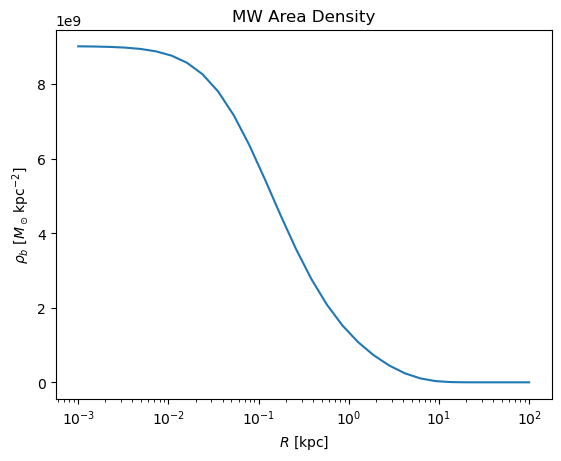

In [6]:
plt.plot(RList,Sigma_b_data)
plt.xscale('log')
plt.title('MW Area Density')
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\rho_b~[M_\odot\,{\rm kpc^{-2}}]$')
plt.show()

### $\rho_b$ with arbitrary $M_G$

For galaxies with arbitrary stellar mass $M_G$, we assume the baryonic profile still follows MW but the corresponding characteristic quantities are scaled with $M_G$. For characteristic radius, we assume it is proportional to $M_G^{1/3}$ and for density is proportional to $M_G$. All these quantities will degenerate to MW's when $M_G=M_{\rm MW}$ where $M_{\rm MW}$ is the MW stellar mass.

The corresponding function is `dukes.galacticDensityProfile(R,z,MG)` where `(R,z,MG)` are in (kpc, kpc, $M_\odot$) and the output is $M_\odot\,{\rm kpc}^{-3}$.

In [7]:
dukes.galacticDensityProfile(5.9,0.1,1e10)

8471024.103398217

We can compare with `dukes.mwDensityProfile`

In [8]:
RList = np.logspace(-3,2,50)
rhob_MW_exact_z0 = []
rhob_MW_scaled_z0 = []
rhob_MW_exact_z01 = []
rhob_MW_scaled_z01 = []
rhob_MW_exact_z5 = []
rhob_MW_scaled_z5 = []
for R in RList:
    rhob_MW_exact_z0.append(dukes.mwDensityProfile(R,0))
    rhob_MW_scaled_z0.append(dukes.galacticDensityProfile(R,0,MG=dukes.constant.Mmw))
    rhob_MW_exact_z01.append(dukes.mwDensityProfile(R,0.1))
    rhob_MW_scaled_z01.append(dukes.galacticDensityProfile(R,0.1,MG=dukes.constant.Mmw))
    rhob_MW_exact_z5.append(dukes.mwDensityProfile(R,5))
    rhob_MW_scaled_z5.append(dukes.galacticDensityProfile(R,5,MG=dukes.constant.Mmw))

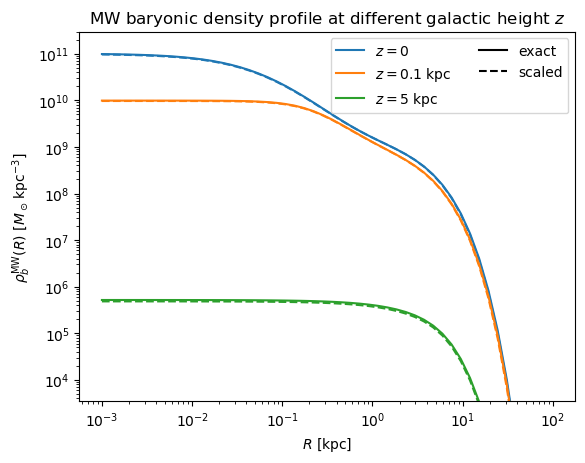

In [9]:
plt.plot(RList,rhob_MW_exact_z0,color='C0',label=r'$z=0$')
plt.plot(RList,rhob_MW_scaled_z0,'--',color='C0')
plt.plot(RList,rhob_MW_exact_z01,color='C1',label=r'$z=0.1$ kpc')
plt.plot(RList,rhob_MW_scaled_z01,'--',color='C1')
plt.plot(RList,rhob_MW_exact_z5,color='C2',label=r'$z=5$ kpc')
plt.plot(RList,rhob_MW_scaled_z5,'--',color='C2')
# for legend plot
plt.plot([1,10],[-1,-1],'k',label='exact')
plt.plot([1,10],[-1,-1],'k--',label='scaled')

plt.title(r'MW baryonic density profile at different galactic height $z$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(3500,3e11)
plt.legend(ncols=2)
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\rho_b^{\rm MW}(R)~[M_\odot\,{\rm kpc}^{-3}]$ ')
plt.show()

The area density for arbitrary $M_G$ can be evaluated by `dukes.galacticAreaDensity(R,zRange=[-10,10],MG=None)` where `R` is in kpc, `zRange` the integration for height $z$ and `MG` the galactic mass. The output is $M_\odot\,{\rm kpc}^{-2}$. If `MG` is `None` then it automatically calls `dukes.mwDensityProfile`, and `dukes.galacticDensityProfile` otherwise.

In [10]:
R,zRange,MG = 5,[-2,18],5.7e9
dukes.galacticAreaDensity(R,zRange,MG)

3164531.512063145

## Dark matter halo profile

We assume that all dark matter (DM) halos enclose galaxies obeying Navarro-Frenk-White (NFW) profile
$$
\rho^{\rm NFW}_\chi(r) = \frac{\rho_s}{\frac{r}{r_s}(1+\frac{r}{r_s})^2}
$$
where $\rho_s$ and $r_s$ are the characteristic density and radius. This profile is spherical symmetric and $r$ is the radial quantity in spherical coordinate that centers GC.
We have a function named `dukes.rhox(r,rhos,rs)` with `(r,rhos,rs)` are in (kpc, MeV cm<sup>−3</sup>, kpc) to evaluate $\rho_\chi^{\rm NFW}$ with output is MeV cm<sup>−3</sup>.

It can be converted to number density $n_\chi$ by dividing the DM mass $m_\chi$,
$$
n_\chi^{\rm NFW}(r)=\frac{\rho^{\rm NFW}_\chi(r)}{m_\chi}.
$$
### $n_\chi^{\rm NFW}$ with arbitrary $M_G$
Bearing the scaling relation for arbitrary $M_G$ in baryonic density distribution, we assume this applies to DM halo shape as well.
We can up or down -scale the halo profile in terms of MW's $(\rho_s^{\rm MW},r_s^{\rm MW})=(184\,{\rm MeV\,cm^{-2}},24.42\,{\rm kpc})$ and $M_G$.
The corresponding fucntion for evaluating DM number density is `dukes.nxNFW(r,mx,rhosMW=184,rs=24.42,MG=None)`, where `mx` is the DM mass in MeV and one can see that the default values `rhosMW` $=\rho_s^{\rm MW}$ and `rsMW` $=r_s^{\rm MW}$.
When `MG` is `None`, it automatically calls the exact MW NFW profile. We can compare

In [11]:
mx = 1e-3
rList = np.logspace(-3,2,50)
mwNFW_exact = []
mwNFW_scaled = []
for r in rList:
    mwNFW_exact.append(dukes.nxNFW(r,mx))
    mwNFW_scaled.append(dukes.nxNFW(r,mx,MG=dukes.constant.Mmw))

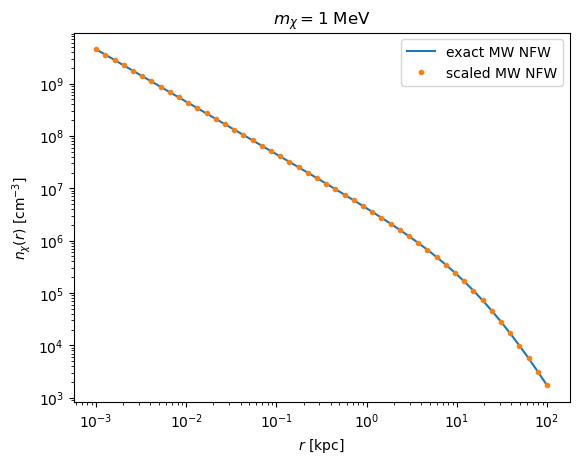

In [12]:
plt.plot(rList,mwNFW_exact,label='exact MW NFW')
plt.plot(rList,mwNFW_scaled,'.',label='scaled MW NFW')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r'$m_\chi = 1$ MeV')
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$n_\chi(r)~[{\rm cm}^{-3}]$')
plt.show()

### Including DM spike

DM can form a spiky structure in the central region of the halo due to the accretion of supermassive black hole (SMBH) and was originally proposed in Gondolo *et al., Rhys. Rev. Lett.* **83** 1719 (1999). In this package, we adopt the parameterization documented in Cline *et al., JCAP* **06**, 004 (2023) with index $\alpha = 3/2$. Other index $\alpha = 7/2$ leads to more spiky shape in the central region and is not implemented.

The function `dukes.dmNumberDensity(r,mx,MG,is_spike=True,sigv=None)` evaluates the DM number density with arbitrary $M_G$ and spike effect included (can be turn on/off). Argument `is_spike` is a boolean and initially set `True` to include the spike effect. If it is set `False` then `dukes.nxNFW` will be called.

Argument `sigv` dicates the DM annihilation cross section $\langle \sigma v\rangle$ in the unit of 10<sup>−26</sup> cm<sup>3</sup> s<sup>−1</sup>. For example, if `sigv=3` it implies $\langle \sigma v\rangle=3\times 10^{-26}~{\rm cm^3~s^{-1}}$. If you wish to turn off DM annihilation, you have to set `sigv=None` instead of `sigv=0`. The later would yield `ZeroDivisionError` in python. Note that `sigv` only works when `is_spike=True`, otherwise, it has no effect.

We evaluate MW DM density (MeV cm<sup>−3</sup>) with spike under different $\langle \sigma v\rangle$ as an example

In [13]:
mx = 1
Mmw = dukes.constant.Mmw
rList = np.logspace(-7,2,50)
rhoxNFW_sigv0 = []
rhoxNFW_sigv3 = []
rhoxNFW_nospike = []
for r in rList:
    rhoxNFW_sigv0.append(dukes.dmNumberDensity(r,mx,MG=Mmw,is_spike=True,sigv=None)*mx)
    rhoxNFW_sigv3.append(dukes.dmNumberDensity(r,mx,MG=Mmw,is_spike=True,sigv=3)*mx)
    rhoxNFW_nospike.append(dukes.dmNumberDensity(r,mx,MG=Mmw,is_spike=False)*mx)  # sigv has no effect whatever value you set

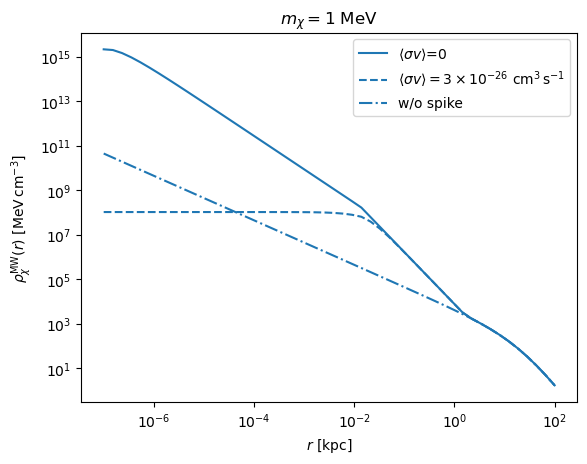

In [14]:
plt.plot(rList,rhoxNFW_sigv0,color='C0',label=r'$\langle \sigma v\rangle$=0')
plt.plot(rList,rhoxNFW_sigv3,'--',color='C0',label=r'$\langle \sigma v\rangle=3\times 10^{-26}~{\rm cm^3\,s^{-1}}$')
plt.plot(rList,rhoxNFW_nospike,'-.',color='C0',label='w/o spike')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r'$m_\chi = 1$ MeV')
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\rho_\chi^{\rm MW}(r)~[{\rm MeV\,cm}^{-3}]$')
plt.show()

## DBDM flux and event calculations

By integrating the contribution of SN$\nu$ BDM coming from all the galaxies at different redshift $z$, we obtain the flux $d\Phi_\chi/dT_\chi$ of diffuse BDM flux at $z=0$,
$$
    \frac{d\Phi_\chi}{dT_\chi} = \frac{v_\chi}{H_0} \int_0^{z_{\rm max}} \frac{dz}{\varepsilon(z)}  \int dM_G \frac{d\Gamma_{{\rm SN}}(z)}{dM_G}\frac{d\bar N_\chi(M_G)}{dT_\chi^\prime} 
$$
where $d\bar{N}_\chi(M_G)/dT_\chi^\prime$ indicates BDM spectrum yielded by the SN located at the most probable place, weighted by the galactic baryonic density $\rho_b(R)$, in the host galaxy, and $T_\chi^\prime=(1+z)T_\chi$ where $T_\chi$ is the observed BDM kinetic energy at $z=0$.

In this package, we provide `dukes.flux` to evaluate the DBDM flux at $z=0$ with isotropic differential DM-$\nu$ cross section in CM frame,
$$
\frac{d\sigma_{\chi\nu}}{d\Omega_{\rm CM}}=10^{-35}~{\rm cm^2~sr^{-1}}.
$$
The integration is powered by `vegas`, a MCMC integrator for evaluating multidimensional integration. This funciton takes 2 positioning arguments and 6 relevant keyword arguments.

`dukes.flux(Tx,mx,is_average=True,R=0,is_spike=True,sigv=None,nitn=10,enval=50000)`:

1. `Tx`: BDM kinetic energy, MeV
2. `mx`: DM mass, MeV
3. `is_average=True`: SN position weighted by $\rho_b$, the most probable position. Set it off will need to specify the SN position at the host galaxy, `R`
4. `R`: User specified SN postion, works for `is_average=False`. Otherwise it has no effect.
5. `is_spike=True`: Is DM spike included in every galaxies?
6. `sigv=None`: DM annihilation cross section in the unit of $10^{-26}~{\rm cm^3~s^{-1}}$. `None` means no annihilation.
7. `nitn=10`: Passed to `vegas`, see its documentation
8. `neval=50000`: Passed to `vegas`, see its documentation

Increasing the values of the last to arguments will yield better accuracy but cost more computation time. This may reduce the fluctuation at high-energy tail. According to `vegas` documentation, one should increase `neval` for better accuracy.

In [15]:
mx = 1e-2
TxList = np.linspace(1,49,25)
pool = mp.Pool(10)
flux_sigv0 = pool.map(partial(dukes.flux,mx=mx,neval=50000),TxList)
flux_sigv3 = pool.map(partial(dukes.flux,mx=mx,sigv=3,neval=50000),TxList)
flux_nospike = pool.map(partial(dukes.flux,mx=mx,is_spike=False,neval=20000),TxList)

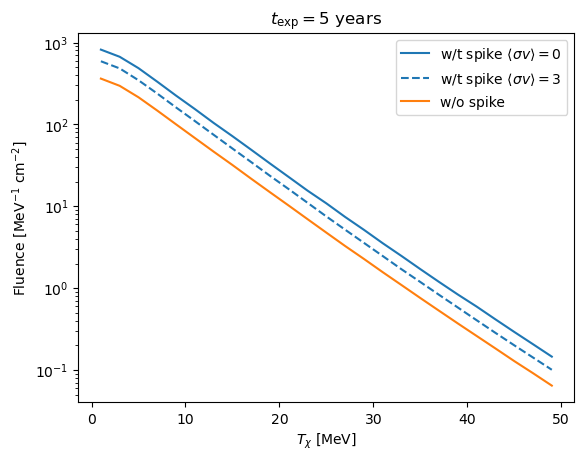

In [16]:
plt.plot(TxList,np.array(flux_sigv0)*5*dukes.constant.year2Seconds,label=r'w/t spike $\langle \sigma v\rangle=0$')
plt.plot(TxList,np.array(flux_sigv3)*5*dukes.constant.year2Seconds,'--',color='C0',label=r'w/t spike $\langle \sigma v\rangle=3$')
plt.plot(TxList,np.array(flux_nospike)*5*dukes.constant.year2Seconds,color='C1',label=r'w/o spike')
plt.yscale('log')
plt.legend()
plt.title(r'$t_{\rm exp}=5$ years')
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'Fluence [MeV$^{-1}$ cm$^{-2}$]')
plt.show()

For DBDM event, one can perform
$$
N_{\rm DBDM} =N_e \int_0^{t_{\rm exp}} dt \int_{T_{\rm min}}^{T_{\rm max}} dT_\chi \frac{d\Phi_\chi}{dT_\chi}  \sigma_{\chi e} = N_e \int dt \times \mathcal{E}.
$$

For event calculation, we provide `dukes.event` to evaluate $\mathcal{E}$ with constant

$$
\frac{d\sigma_{\chi e}}{d\Omega_{\rm CM}}=10^{-35}~{\rm cm^2~sr^{-1}}.
$$

It takes one positioning argument `mx`, which is DM mass in MeV, and a keyword argument `TxRange=[5,100]` dictates the range $(T_{\rm min},T_{\rm max})$ in MeV.
Other keyword arguments are identical to `dukes.flux`. Note that  $\mathcal{E}$ hs unit per electron per second. Since the DBDM flux is stationary, $N_{\rm DBDM}$ can be simplified as
$$
N_{\rm DBDM} = N_e t_{\rm exp} \times \mathcal{E}
$$
where $t_{\rm exp}$ is the exposure time and $N_e$ the total electron number of a detector. For Hyper-K, $N_e\approx 3\times 10^{34}$ and suppose $t_{\rm exp}=5$ years,

In [17]:
# Evaluating DBDM event
mx = 1e-2
E_sigv0 = dukes.event(mx=mx,TxRange=[5,30],neval=50000)
E_sigv3 = dukes.event(mx=mx,TxRange=[5,30],sigv=3,neval=50000)
E_nospike = dukes.event(mx=mx,TxRange=[5,30],is_spike=False,neval=20000)

Ne = 3e34
texp = 5*dukes.constant.year2Seconds
print(f'N_DBDM in Hyper-K in 5-year exposure are {E_sigv0*Ne*texp:.2f} for sigv=0, {E_sigv3*Ne*texp:.2f} for sigv=3, and {E_nospike*Ne*texp:.2f} for no spike.')

N_DBDM in Hyper-K in 5-year exposure are 9589.94 for sigv=0, 6806.95 for sigv=3, and 4226.92 for no spike.


## Miscellaneous functions

### Correlation between SMBH mass and $M_G$

Emprically, the SMBH mass $M_{\rm BH}$ is correlated to its host galaxy with mass $M_G$ by
$$
M_{\rm BH}\sim 10^7\times \left(\frac{\eta M_G}{10^{12}M_\odot}\right)^{4/3}
$$
where $\eta\equiv M_{\rm Halo}/M_G$ is the ratio of DM halo mass to galactic mass. We assume an universal $\eta =24.38$ which is derived from MW. The function `dukes.massBH(MG,eta=24.38)` evaluates $M_{\rm BH}$ in the unit of $M_\odot$.
 
### Schwarzschild radius

The Schwarzschild radius of a SMBH is
$$
R_S =\frac{GM_{\rm BH}}{c^2}
$$
and is evaluated by `dukes.radiuSchwarzschild(mBH)` with input `mBH` is in $M_\odot$ and output is in kpc.

### Supernova neutrino energy spectrum
The SN$\nu$ energy spectrum
$$
\frac{dn_{\nu}}{dE_{\nu}} =\sum_{i}\frac{L_{\nu_{i}}}{4\pi \ell^{2}\langle E_{\nu_{i}}\rangle}E_{\nu}^{2}f_{\nu_{i}}(E_{\nu}),
$$
where $L_{\nu_{i}}$ is the luminosity  of each flavor $i$ and $\ell$ is the neutrino propagation distance after it was emitted.
The function `dukes.supernovaNuFlux(Ev,l)` evaluates such spectrum with arguments `(Ev,l)` are in (MeV, kpc) and the output is ${\rm MeV^{-1}~cm^{-2}~s^{-1}}$. The unit per second accounts for the average over the explosion duration $\tau=10~{\rm s}$.

### BDM velocity

The BDM velocity $v_\chi/c$ for a given $m_\chi$ and kinetic energy $T_\chi$ is
$$
\frac{v_\chi}{c} = \frac{\sqrt{T_\chi (T_\chi+2m_\chi)}}{T_\chi+m_\chi}.
$$
Note that $T_\chi +m_\chi= \gamma m_\chi = m_\chi/\sqrt{1-v_\chi^2/c^2}$. The function `dukes.vBDM(Tx,mx)` evaluates $v_\chi/c$ where `Tx` and `mx` have to be the same unit, e.g. MeV.

## *Experimental* :: Implementation of model-dependent differential cross section

In the previous section, the differential cross sections are assumed energy-independent and isotropic in CM frame. This yields a simple expression for both DM-$\nu$ and DM-$e$ interactions
$$
\frac{d\sigma_{\chi\nu,e}}{d\Omega_{\rm CM}}=\frac{\sigma_0}{4\pi}.
$$
However, by introducing a phenomenological model, e.g. $L_\mu-L_\tau$, a Lagrangian that gauges the particle interactions exists
$$
\mathcal{L}_{\rm int} = g_\chi V_\mu\bar{\chi}\gamma^\mu  \chi + g_V V_\mu Q_{\alpha\beta}(\bar{\ell}_\alpha\gamma^\mu \ell_\beta +\bar{\nu}_\alpha \gamma^\mu P_L \nu_\beta)
$$
where $Q_{\alpha\beta}={\rm diag}(0,1,-1)$. In the above, $\chi$ is the fermionic DM field, and a new $U(1)$ gauge boson $V$ with mass $m_V$ is introduced and couples to both $\chi$ and SM lepton and neutrino fields, $\ell$ and $\nu$ respectively. The greek symbols $\alpha,\beta=e,\mu,\tau$.

Through $\mathcal{L}_{\rm int}$, the associated interaction cross sections are in general energy-dependent and not isotropic in CM frame. The Feynman diagrams for these two interactions are
<div style="text-align:center"><img src="feynman_xv.png" alt="DM-v interaciton" width="25%" height="auto">$\qquad$<img src="feynman_xe.png" alt="DM-e interaciton" width="25%" height="auto"></div>
Left is for $\chi \nu$ and right for $\chi e$ scatterings. The differential cross sections take identical form in CM frame,
$$
\frac{d\sigma}{d\Omega_{\rm CM}}= \frac{|\mathcal{M}|^2}{64\pi^2 s}.
$$
The scattering amplitude is
$$
|\mathcal{M}|^{2}  =2\left(\frac{\mathcal{Q}}{t-m_{V}^{2}}\right)^{2}(s^{2}+u^{2}+4t(m_{1}^{2}+m_{2}^{2}) -2(m_{1}^{2}+m_{2}^{2})^{2})
$$
where $\mathcal{Q}=g_V g_\chi$ and $g_\chi \varepsilon e$ for $\chi \nu$ and $\chi e$ interactions respectively, and $s,t,u$ are the Mandelstam variables. $m_{1,2}$ are the masses of two incoming particles.

Suppose $m_2$ is always at rest in the lab frame. It is true for $\chi\nu$ scattering as halo DM is generally assumed non-relativistic. So does $\chi e$ interaction in the detector where $e$ is bound to the nucleus.
Thus, we construct the Mandelstam variables (see Ilisie, *Concepts in Quantum Field Theory: A Practitioner's Toolkit*, Springer 2016) in the following.

### $\chi \nu$ scattering

Assuming $p_{\nu,{\rm lab}}^\mu=(E_\nu,\mathbf{p}_\nu)$ and $p_{\chi,{\rm lab}}^\mu=(m_\chi,\mathbf{0})$ thus
\begin{align*}
s & =(p_{\nu,{\rm lab}}^{\mu}+p_{\chi,{\rm lab}}^{\mu})^{2}=m_{\chi}^{2}+2E_{\nu}m_{\chi},\\
t & =-2(E_{\nu,{\rm cm}}^{2}-|\mathbf{p}_{\nu,{\rm cm}}|^{2}), \\
u & = 2m_\chi^2 - s-t,
\end{align*}
where
\begin{align*}
E_{\nu,{\rm cm}} & =\frac{1}{2\sqrt{s}}(s-m_{\chi}^{2}),\\
|\mathbf{p}_{\nu,{\rm cm}}| & =\frac{1}{2\sqrt{s}}\lambda^{1/2}(s,0,m_{\chi}^{2}),
\end{align*}
and
$$
\lambda(x,y,z) = x^2+y^2+z^2-2xy-2yz-2zx.
$$
is the Kallen lambda function.

### $\chi e$ scattering

Similarily, $p_{\chi,{\rm lab}}^\mu=(E_\chi,\mathbf{p}_\chi)$ and $p_{e,{\rm lab}}^\mu=(m_e,\mathbf{0})$ thus
\begin{align*}
s & =(p_{\chi,{\rm lab}}^{\mu}+p_{e,{\rm lab}}^{\mu})^{2}=m_{\chi}^{2}+m_e^2+2E_{\chi}m_{e},\\
t & =-2(E_{\chi,{\rm cm}}^{2}-|\mathbf{p}_{\chi,{\rm cm}}|^{2}), \\
u & = 2(m_\chi^2+m_e^2) - s -t
\end{align*} 
where $E_\chi = T_\chi + m_\chi$ and
\begin{align*}
E_{\chi,{\rm cm}} & =\frac{1}{2\sqrt{s}}(s+m_{\chi}^{2}-m_e^2),\\
|\mathbf{p}_{\chi,{\rm cm}}| & =\frac{1}{2\sqrt{s}}\lambda^{1/2}(s,m_{\chi}^{2},m_e^2).
\end{align*}


### Engaging with user-defined pheno model

We have a class named `userPhenoModelInterface` in `dukes.utils` to engage with user-defined model. This class is not loaded automatically in the beginning but can be imported via

In [18]:
from dukes.utils import userPhenoModelInterface

To initialize model-dependent instance from `userPhenoModelInterface`, it takes **2** *functional arguments*: `func1` and `func2`. The first `func1` represents the funciton of $\chi\nu$ differential scattering cross section and the second `func2` the function of $\chi e$ differential scattering cross section.

Each `func` can **ONLY** have **3** *positioning arguments*: `func1(arg1, arg2, arg3)`. The meanings of these arguments are:

1. `arg1`: The energy (MeV) of the incoming particle in lab frame. It is $E_\nu$ for $\chi \nu$ scattering and $T_\chi$ for $\chi e$ scattering. 
2. `arg2`: The DM mass (MeV).
3. `arg3`: Scattering angle (rad) in CM frame.

In the above example, we can see that `arg3` is simply a placeholder, as $(s,t,u)$ do not dependent on the scattering angle. Now we can construct `func1` and `func2` along with their auxiliary functions:

In [19]:
# Kallen lambda
_lambda = lambda x,y,z: x**2 + y**2 + z**2 - 2*(x*y + y*z + x*z)

# amplitude-square
# Note that Q is simply a constant and can be factored out
def amplitude2(s,t,u,m1,m2,mV):
    return 2*(s**2 + u**2 + 4*t*(m1**2 + m2**2) - 2*(m1**2 + m2**2)**2)/(t - mV**2)**2

# convert 1/MeV**2 to cm**2
to_cm2 = (1.973e-11)**2

# xv
def func1(Ev,mx,theta) -> float:   # the inputs are positioning arguments and the order is strict
    s = mx**2 + 2*Ev*mx
    Evcm2 = (s - mx**2)**2/4/s
    pvcm2 = _lambda(s,0,mx**2)/4/s
    t = -2*(Evcm2 - pvcm2)
    u = 2*mx**2 - s - t
    M2 = amplitude2(s,t,u,m1=0,m2=mx,mV=mx)    # assuming massless neutrino and mV = mx
    diffcrox = M2/64/np.pi**2/s*to_cm2
    return diffcrox

# xe
def func2(Tx,mx,theta) -> float:   # the inputs are positioning arguments and the order is strict
    me = dukes.constant.me
    Ex = Tx + mx    # reconstruct Ex from Tx and mx
    s = mx**2 + me**2 + 2*Ex*me
    Excm2 = (s + mx**2 - me**2)**2/4/s
    pxcm2 = _lambda(s,mx**2,me**2)/4/s
    t = -2*(Excm2 - pxcm2)
    u = 2*(mx**2 + me**2) - s - t
    M2 = amplitude2(s,t,u,m1=mx,m2=me,mV=mx)    # assuming mV = mx
    diffcrox = M2/64/np.pi**2/s*to_cm2
    return diffcrox

We have sucessfully built the functions for cross section. For instance, suppose $(g_V,g_\chi)=(10^{-9},10^{-2})$, $(E_\nu,m_\chi)=(10,10^{-3})\,{\rm MeV}$ and $m_V=m_\chi$, then $d\sigma_{\chi\nu}/d\Omega_{\rm CM}$ is

In [20]:
gV,gx = 1e-9,1e-2
Qv = gV*gx
func1(10,1e-3,0)*Qv**2  # cm^2

4.9299523758668815e-36

Now we begin by initializing model instance via `userPhenoModelInterface`

In [21]:
myOwnModel = userPhenoModelInterface(func1,func2)

Both model-dpendent DBDM flux and event can be evaluated by attaching suffixes `.flux` and `.event` respectively. In fact, these two suffixes take the same input arguments as `dukes.flux` and `dukes.event`.

In [22]:
Tx,mx = 10,1e-3
dbdmFlux = myOwnModel.flux(Tx=Tx,mx=mx,neval=50000)
dbdmEvent = myOwnModel.event(mx=mx,neval=50000)

Note `dbdmFlux` still missing the $\mathcal{Q}_\nu^2=g_V^2 g_\chi^2$ because we did not include it in the `func1`. The true flux would be, suppose $(g_V,g_\chi)=(10^{-9},10^{-2})$,

In [23]:
dbdmFlux *= Qv**2
print(f'The DBDM flux is {dbdmFlux} per MeV per cm^2 per s at Tx = 10 MeV')

The DBDM flux is 1.4691933585539104e-05 per MeV per cm^2 per s at Tx = 10 MeV


For event, we need another $\mathcal{Q}_e^2 = g_\chi^2\varepsilon^2 e^2=g_\chi^2\varepsilon^2 (4\pi \alpha)$ where $\alpha \approx 1/137$ is the fine-structure constant. Suppose $\varepsilon = -g_V$, we have

In [24]:
eps = gV
Qe = gx*eps*np.sqrt(4*np.pi/137)
dbdmEvent *= Qv**2*Qe**2
print(f'The DBDM event is {dbdmEvent} per electron per s')

The DBDM event is 6.776800501317265e-38 per electron per s


Note that this is the event per electron per second. For an underground detector like Hyper-K, it contains $7\times 10^{34}$ electrons. Given such model setup, Hyper-K would measure

In [25]:
dbdmEvent_in_HK = dbdmEvent*7e34
print(f'HK would measure {dbdmEvent_in_HK} DBDM events per second given such setup')

HK would measure 0.004743760350922085 DBDM events per second given such setup
